# Depth findings in Movies

## II. User profiles

In this section, we try to build user profiles, looking for user with high participation on rankings. We want to discover the preferences of people, according genres, description of movies and key-words. 

### Importing Data

Importing relevant packages:

In [2]:
import re
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Importing movies and ratings datasets:

In [3]:
df_movies = pd.read_csv('../Data/interim/movies/movies.csv')

In [4]:
df_movies.rename(columns = {'Unnamed: 0': 'counter'}, inplace=True)

In [5]:
df_movies.head(2)

,counter,adult,belongs_to_collection,genres,id,original_language,overview,popularity,production_companies,production_countries,...,Foreign,History,Horror,Music,Mystery,Romance,Thriller,War,Western,key_list
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['jealousy', 'toy', 'boy', 'friendship', 'frie..."
1,1,False,NaN,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['disappearance', 'recluse']"


In [6]:
df_ratings = pd.read_csv('../Data/raw/movies/the-movies-dataset/ratings.csv')

In [7]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


As we can note, the rating dataset contains `userId`, `movieId` and `rating`. Grouping by users, we could determine which users are actively voting movies and they could bring us more information to generate profiles: 

In [8]:
df_users = df_ratings.groupby('userId').count().movieId

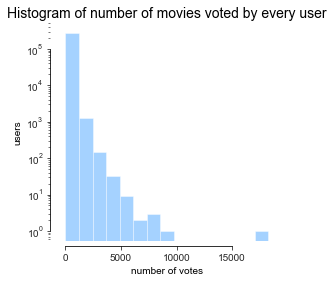

In [9]:
f, ax = plt.subplots(figsize=(4, 4))
_ = sns.set_style("white")
ax = sns.distplot(df_users, kde=False, bins=15, color='dodgerblue')
ax.set_yscale('log')
_ = plt.xlabel('number of votes', fontsize=10)
_ = plt.ylabel('users', fontsize=10)
_ = plt.title('Histogram of number of movies voted by every user', fontsize=14)
_ = sns.despine(offset=5, trim=True)

According to the Figure, almost all people vote 1-5000 movies. Inspecting percentiles, we could get values to filter users:

In [10]:
print('Percentiles 80 = {}'.format(np.percentile(df_users.values, 80)) + '\nPercentile 95 = {}'.format(np.percentile(df_users.values, 95)))

Percentiles 80 = 119.0
Percentile 95 = 398.0


80% of users had voted less than 120 movies and 95% of people sum up less than 400 movies. Therefore, the users with frecuencies lower than 120 movies and upper than 400 are filtered:

In [11]:
users_idx = df_users.where((df_users.values > 120) & (df_users.values < 400)).dropna()
print(len(users_idx))

40301


Filtering the users from the ratings dataFrame and then merging with the movies dataset:

In [12]:
df_ratings_filter = df_ratings[df_ratings['userId'].isin(users_idx.index.tolist())]

In [13]:
df_movies_rating = df_movies.merge(df_ratings_filter, left_on='id', right_on='movieId')

In [14]:
df_movies_rating_group = df_movies_rating.groupby('userId').count()
df_movies_rating_group.head()

,counter,adult,belongs_to_collection,genres,id,original_language,overview,popularity,production_companies,production_countries,...,Music,Mystery,Romance,Thriller,War,Western,key_list,movieId,rating,timestamp
userId,,,,,,,,,,,,,,,,,,,,,
11,67,67,17,67,67,67,67,67,67,67,...,3,8,7,17,2,1,67,67,67,67
12,136,136,28,136,136,136,135,136,136,136,...,3,14,26,32,1,3,136,136,136,136
15,77,77,13,77,77,77,76,77,77,77,...,4,7,11,23,1,0,77,77,77,77
16,54,54,8,54,54,54,54,54,54,54,...,1,3,10,15,2,5,54,54,54,54
20,86,86,18,86,86,86,86,86,86,86,...,0,8,11,19,5,2,86,86,86,86


After merging datasets, we loss information from users and movies. Again, we filter users using the previously got percentiles 85 and 90:

In [15]:
users_idx_filter = df_movies_rating_group.where((df_movies_rating_group.counter > 120) & (df_movies_rating_group.counter < 400)).dropna()

In [16]:
len(users_idx_filter)

9246

In [17]:
df_user_sample = users_idx_filter.sample(frac=0.1)

In [18]:
df_movies_rating_filter = df_movies_rating[df_movies_rating['userId'].isin(df_user_sample.index.tolist())]

Building a copy of dataframe:

In [21]:
df_mov_rating = df_movies_rating_filter.copy()

Selecting columns for the analysis:

In [22]:
df_mov_rating = df_mov_rating.loc[:, ['userId', 'movieId', 'title', 
                       'overview', 'spoken_languages', 
                       'rating', 'genres_list', 'key_list', 
                       'vote_count', 'vote_average',
                       'runtime', 'release_date']]

In [23]:
df_mov_rating.head(2)

,userId,movieId,title,overview,spoken_languages,rating,genres_list,key_list,vote_count,vote_average,runtime,release_date
1,6525,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'iso_639_1': 'en', 'name': 'English'}]",4.0,"['Animation', 'Comedy', 'Family']","['jealousy', 'toy', 'boy', 'friendship', 'frie...",5415.0,7.7,81.0,1995-10-30
18,60313,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'iso_639_1': 'en', 'name': 'English'}]",4.0,"['Animation', 'Comedy', 'Family']","['jealousy', 'toy', 'boy', 'friendship', 'frie...",5415.0,7.7,81.0,1995-10-30


Multi-indexing by users and movies:

In [24]:
df_user = df_mov_rating.set_index(['userId', 'movieId']).sort_values('userId')
#df_user.reset_index()

In [25]:
df_user.head(2)

title  \
userId movieId                  
65     1485        Get Carter   
       1480     Touch of Evil   

                                                         overview  \
userId movieId                                                      
65     1485     Michael Caine is Jack Carter, a small-time hoo...   
       1480     Stark, perverse story of murder, kidnapping, a...   

                                                 spoken_languages  rating  \
userId movieId                                                              
65     1485              [{'iso_639_1': 'en', 'name': 'English'}]     3.0   
       1480     [{'iso_639_1': 'en', 'name': 'English'}, {'iso...     3.0   

                                   genres_list  \
userId movieId                                   
65     1485              ['Crime', 'Thriller']   
       1480     ['Drama', 'Thriller', 'Crime']   

                                                         key_list  vote_count  \
userId movieId                                                                  
65     1485                       ['hitman', 'british', 'gritty']       122.0   
       1480     ['hotel', 'brothel', 'border', 'evidence', 'ho...       292.0   

                vote_average  runtime release_date  
userId movieId                                      
65     1485              6.9    112.0   1971-03-03  
       1480              7.6     95.0   1958-04-23

Build a dictionary of userId, genres and genres (to count the number of movies depending on the genres and how the user qualify every genre).

In [26]:
genres = []
rating = []
userId = []
movieId = []
vote_average = []

for i in range(df_user.shape[0]):
    a, b = df_user.index[i][0], df_user.index[i][1]
    try:
        df_user.genres_list[a, b].split(',')
    except:
        continue
    for g in df_user.genres_list[a, b].split(','):
        g = g.replace('[','').replace(']','').replace("'", "").replace(" ", "")
        
        userId.append(a)
        movieId.append(b)
        genres.append(g)
        rating.append(df_user.rating[a, b])
        vote_average.append(df_user.vote_average[a, b])
        
df_users_profiles = pd.DataFrame({'userId': userId, 
                                  'movieId': movieId, 
                                  'genre': genres, 
                                  'rating': rating, 
                                  'vote_average': vote_average})       

/Users/daniela/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


Checking genres:

In [27]:
df_users_profiles.genre.unique()

array(['Crime', 'Thriller', 'Drama', 'Fantasy', 'Comedy', 'Action',
       'Adventure', 'Romance', 'Horror', 'Animation', 'Family', 'Mystery',
       'Western', 'War', 'History', 'Documentary', 'Music', 'Foreign'],
      dtype=object)

In [51]:
#df_users_profiles.userId.unique()

Now, we use the information about a specific user and his preferences in genres. To visualize that, boxplots of every genre are displayed below, showing the votes that this user did for movies belongs to every genre:

361


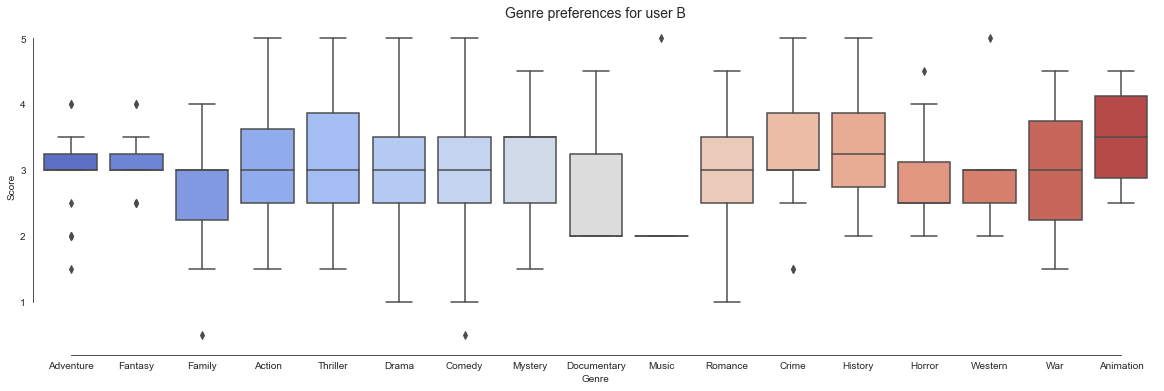

In [32]:
df_example = df_users_profiles[df_users_profiles.userId == 766]

f, ax = plt.subplots(figsize=(20, 6))
_ = sns.set_style("white")
_ = sns.boxplot(x='genre', y='rating', data=df_example, palette='coolwarm')
_ = plt.title('Genre preferences for user B', fontsize=14)
_ = plt.xlabel('Genre', fontsize=10)
_ = plt.ylabel('Score', fontsize=10)
_ = sns.despine(offset=5, trim=True)

The boxplots of average ratings from the movies in this sample is displayed below. As we can see, every genre offers a different distribution of scores:

In [48]:
def rescale(data):
    x = ((5 - 0)*(data - 0)/(10-0)) + 0
    return x

/Users/daniela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


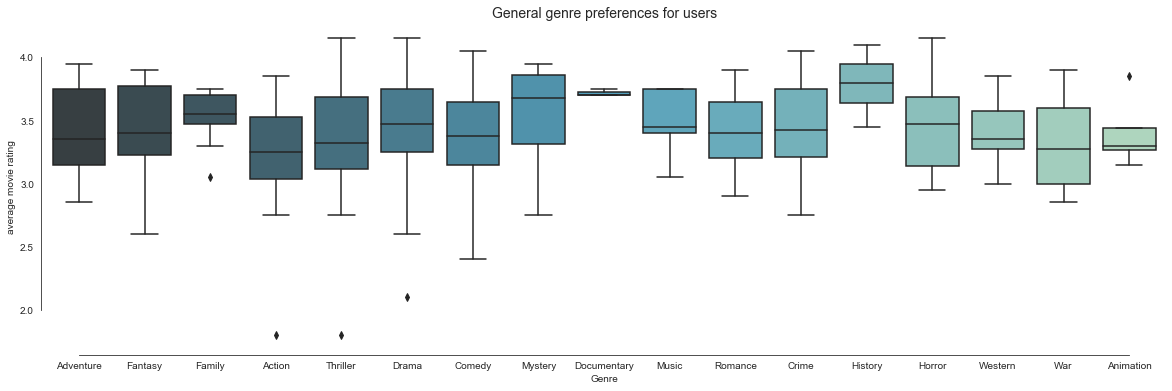

In [50]:
df_example['vote_average_rescaled'] = df_example.vote_average.apply(rescale)

f, ax = plt.subplots(figsize=(20, 6))
_ = sns.set_style("white")
_ = sns.boxplot(x='genre', y='vote_average_rescaled', data=df_example, palette='GnBu_d')
_ = plt.title('General genre preferences for users', fontsize=14)
_ = plt.xlabel('Genre', fontsize=10)
_ = plt.ylabel('average movie rating', fontsize=10)
_ = sns.despine(offset=5, trim=True)

In [128]:
df = df_users_profiles.groupby(['userId', 'genre']).rating.agg(['mean', 'std', 'min', 'max', 'count'])
df.head()

mean       std  min  max  count
userId genre                                         
65     Action     3.794118  1.094875  1.0  5.0     34
       Adventure  3.869565  1.099766  1.0  5.0     23
       Animation  4.166667  0.752773  3.0  5.0      6
       Comedy     3.555556  0.924849  1.0  5.0     54
       Crime      3.783784  0.854242  3.0  5.0     37

Algorithm to calculate rating of genres, adapted from https://math.stackexchange.com/questions/942738/algorithm-to-calculate-rating-based-on-multiple-reviews-using-both-review-score

In [129]:
from math import exp

def genres_ranking_by_user(df):
    """
    We adapt the algorithm describe on the link below to get a coefficient that represent
    the popularity of the genre for every user. This popularity depend on the number of movies 
    watched belongs to specific genre and the average rating for the same genre.
    """
    genres_ranking = []
    Q = max(df.loc[:, 'count'])
    #Q = 144
    for idx in df.index:
        p = df.loc[idx, 'mean']
        q = df.loc[idx, 'count']
        score = 5*p/10 + 5*(1 - exp(-q/Q))
        genres_ranking.append(score)
        
    return genres_ranking

In [130]:
df['ranking_genres'] = genres_ranking_by_user(df)

In [131]:
df.head(18)

mean       std  min  max  count  ranking_genres
userId genre                                                           
65     Action       3.794118  1.094875  1.0  5.0     34        2.870640
       Adventure    3.869565  1.099766  1.0  5.0     23        2.616140
       Animation    4.166667  0.752773  3.0  5.0      6        2.270811
       Comedy       3.555556  0.924849  1.0  5.0     54        3.232953
       Crime        3.783784  0.854242  3.0  5.0     37        2.941680
       Documentary  3.750000  0.500000  3.0  4.0      4        2.000779
       Drama        3.725490  0.986612  1.0  5.0    102        4.251685
       Family       4.222222  0.666667  3.0  5.0      9        2.389675
       Fantasy      3.416667  1.164500  1.0  5.0     12        2.076259
       Foreign      2.000000       NaN  2.0  2.0      1        1.031746
       History      3.875000  0.834523  3.0  5.0      8        2.185895
       Horror       3.636364  0.924416  3.0  5.0     11        2.156510
       Music        3.375000  1.060660  2.0  5.0      8        1.935895
       Mystery      4.375000  0.806226  3.0  5.0     16        2.671950
       Romance      3.621622  0.892915  2.0  5.0     37        2.860599
       Thriller     3.800000  0.966092  2.0  5.0     40        3.024554
       War          4.333333  0.577350  4.0  5.0      3        2.261301
       Western      3.571429  0.975900  2.0  5.0      7        2.003747

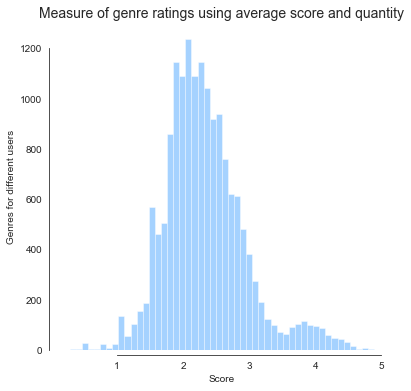

In [143]:
f, ax = plt.subplots(figsize=(6, 6))
_ = sns.set_style("white")
_ = sns.distplot(df['ranking_genres'], color='dodgerblue', kde=False)
_ = plt.title('Measure of genre ratings using average score and quantity', fontsize=14)
_ = plt.xlabel('Score', fontsize=10)
_ = plt.ylabel('Genres for different users', fontsize=10)
_ = sns.despine(offset=5, trim=True)

In [144]:
from scipy.stats import kurtosis, skew

print('kurtosis = {}'.format( kurtosis(df['ranking_genres'].values) ))
print('skewness = {}'.format( skew(df['ranking_genres'].values) ))

kurtosis = 1.459290412055446
skewness = 0.8213934467931712


In [133]:
df_reindex = df.reset_index()

df_pivot = df_reindex.pivot(index='userId', columns='genre', values='ranking_genres')
df_pivot.head()

genre,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,
65,2.870640,2.616140,2.270811,3.232953,2.941680,2.000779,4.251685,2.389675,2.076259,1.031746,2.185895,2.156510,1.935895,2.671950,2.860599,3.024554,2.261301,2.003747
674,2.638156,2.425178,1.812478,2.675126,2.399801,1.896605,3.433499,1.861897,1.810895,1.656727,1.813279,2.108874,1.770811,2.201259,2.372546,2.796338,1.927968,2.000779
766,2.388156,2.159618,1.875779,2.710083,2.267399,1.511301,3.779040,1.633782,2.005596,NaN,1.813279,1.906325,1.456727,2.046950,2.136023,2.673553,1.625779,1.718033
817,2.796023,2.721944,2.031746,2.984406,2.624941,2.056727,3.790545,1.932319,2.288930,2.031746,2.075176,2.356727,2.375779,2.640844,2.691727,2.978156,2.563290,2.063290
1014,2.827498,2.576522,2.056727,3.346423,2.709324,1.520811,4.225812,1.858541,2.062853,NaN,2.000779,2.254125,2.242926,2.456664,2.727996,3.361212,1.813290,2.056727


In [134]:
df_pivot.fillna(0, inplace=True)

In [135]:
from sklearn.metrics import pairwise_distances

cosine_sim = 1-pairwise_distances(df_pivot, metric="cosine")

In [136]:
pd.DataFrame(cosine_sim).head()

,0,1,2,3,4,5,6,7,8,9,...,915,916,917,918,919,920,921,922,923,924
0,1.000000,0.994347,0.992277,0.991258,0.990956,0.991820,0.991481,0.996820,0.991082,0.992533,...,0.992044,0.993511,0.994451,0.984467,0.991214,0.993271,0.994387,0.997545,0.994626,0.992098
1,0.994347,1.000000,0.980468,0.997595,0.980299,0.997318,0.995559,0.995625,0.977730,0.997755,...,0.996645,0.979267,0.994029,0.993483,0.996130,0.988955,0.997459,0.994116,0.995306,0.981599
2,0.992277,0.980468,1.000000,0.975001,0.997034,0.976619,0.979603,0.987699,0.996241,0.976989,...,0.975580,0.996348,0.985090,0.969100,0.976054,0.989540,0.980266,0.991165,0.981999,0.995544
3,0.991258,0.997595,0.975001,1.000000,0.975630,0.995852,0.993355,0.991713,0.973403,0.995614,...,0.996082,0.974471,0.993565,0.990707,0.994969,0.983165,0.995471,0.991385,0.993043,0.977076
4,0.990956,0.980299,0.997034,0.975630,1.000000,0.976646,0.978206,0.985159,0.994582,0.977205,...,0.976034,0.995215,0.984750,0.970735,0.977306,0.989060,0.977181,0.989647,0.981170,0.994675


The following function find k similar users. We select four and compare the corrected genre scores using linear plots of every user.

In [253]:
from sklearn.neighbors import NearestNeighbors

#This function finds k similar users given the user_id and ratings matrix M
#Note that the similarities are same as obtained via using pairwise_distances

def findksimilarusers(userId, ratings, metric = metric, k=k, verbose=True):
    user_id = userId + 1
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric) 
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(ratings.iloc[user_id-1, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    if verbose:
        print ('{} most similar users for User {}:\n'.format(k,userId))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id:
            continue;

        else:
            if verbose:
                print ('{}: User {}, with similarity of {}'.format(i, indices.flatten()[i], similarities.flatten()[i]))
            
    return similarities,indices

In [246]:
similarities,indices = findksimilarusers(0, df_pivot, metric='cosine', k=4)

4 most similar users for User 0:

1: User 163, with similarity of 0.997919159511408
2: User 760, with similarity of 0.9976587038389682
3: User 922, with similarity of 0.9975450184382024
4: User 78, with similarity of 0.9974103171879882


In [195]:
df_similar_users = pd.concat([df_pivot.iloc[0, :].rename('user'), 
                              df_pivot.iloc[163, :].rename('first similar'), 
                              df_pivot.iloc[760, :].rename('second similar'),
                              df_pivot.iloc[922, :].rename('third similar'),
                              df_pivot.iloc[78, :].rename('fourth similar')
                              ], axis=1)

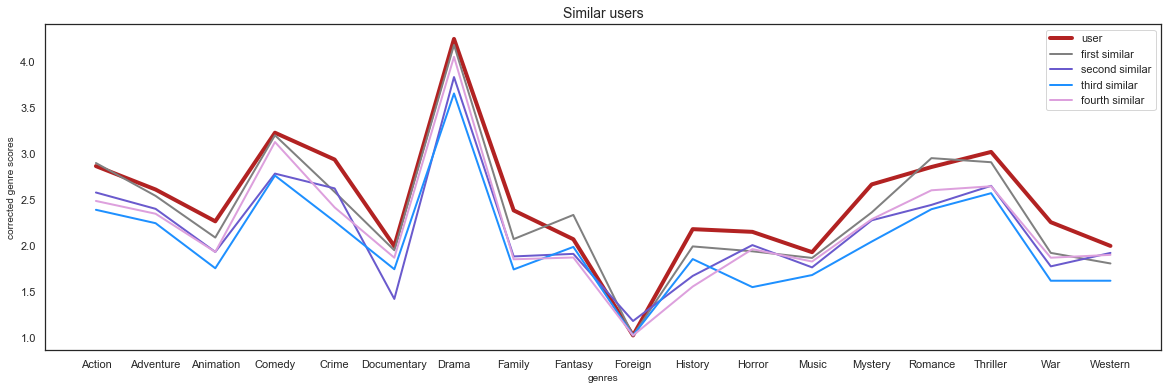

In [194]:
f, ax = plt.subplots(figsize=(20, 6))
_ = sns.set_style("white")
_ = sns.lineplot(data=df_similar_users['user'], color='firebrick', linewidth=4)
_ = sns.lineplot(data=df_similar_users['first similar'], color='grey', linewidth=2)
_ = sns.lineplot(data=df_similar_users['second similar'], color='slateblue', linewidth=2)
_ = sns.lineplot(data=df_similar_users['third similar'], color='dodgerblue', linewidth=2)
_ = sns.lineplot(data=df_similar_users['fourth similar'], color='plum', linewidth=2)
_ = plt.legend(['user', 'first similar', 'second similar', 'third similar', 'fourth similar'])
_ = plt.title('Similar users', fontsize=14)
_ = plt.xlabel('genres', fontsize=10)
_ = plt.ylabel('corrected genre scores', fontsize=10)

In [299]:
#This function predicts rating for specified user-item combination based on user-based approach
def predict_userbased(userId, item_id, ratings, metric = metric, k=k, verbose=True):
    user_id = userId + 1
    prediction=0
    similarities, indices=findksimilarusers(userId, ratings,metric, k, verbose=False) #similar users based on cosine similarity
    mean_rating = ratings.iloc[user_id-1,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_id-1]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    prediction = mean_rating + (wtd_sum/sum_wt)
    if verbose:
        print ('\nFor user {} and item {}, the predicted score is {}'.format(userId,item_id-1,prediction))

    return prediction

Predicting scores for every genre of User 0:

In [300]:
prediction = []
for i in range(18):
    p = predict_userbased(0, i+1, df_pivot, metric='cosine', k=4, verbose=False)
    prediction.append(p)
    
df_similar_users['prediction'] = prediction

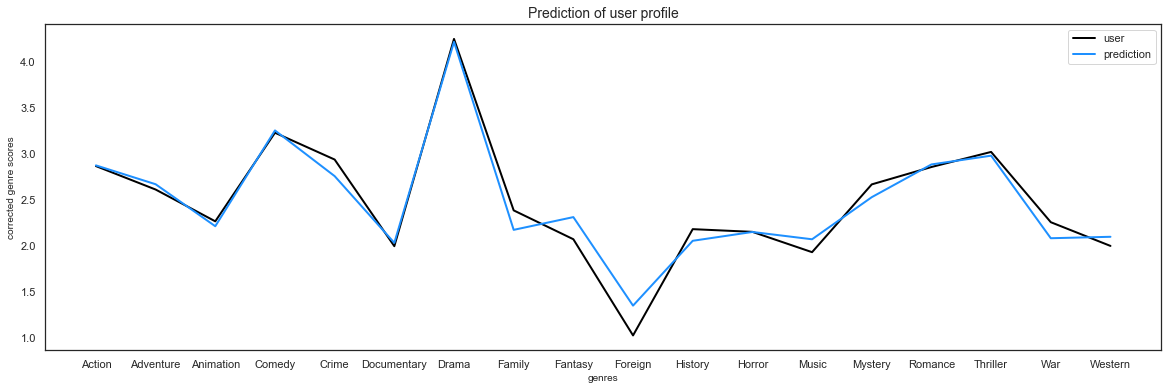

In [303]:
f, ax = plt.subplots(figsize=(20, 6))
_ = sns.set_style("white")
_ = sns.lineplot(data=df_similar_users['user'], color='black', linewidth=2)
_ = sns.lineplot(data=df_similar_users['prediction'], color='dodgerblue', linewidth=2)
_ = plt.legend(['user', 'prediction'])
_ = plt.title('Prediction of user profile', fontsize=14)
_ = plt.xlabel('genres', fontsize=10)
_ = plt.ylabel('corrected genre scores', fontsize=10)

In [302]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_similar_users['user'].values, df_similar_users['prediction'].values)

0.019235046393525308